<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes" data-toc-modified-id="Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step 1: Load the Data/Filtering for Chosen Zipcodes</a></span></li><li><span><a href="#Step-2:-Data-Preprocessing" data-toc-modified-id="Step-2:-Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Step 2: Data Preprocessing</a></span></li><li><span><a href="#Step-3:-EDA-and-Visualization" data-toc-modified-id="Step-3:-EDA-and-Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 3: EDA and Visualization</a></span></li><li><span><a href="#Step-4:-SARIMA-modelling-on-averaged-prices" data-toc-modified-id="Step-4:-SARIMA-modelling-on-averaged-prices-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step 4: SARIMA modelling on averaged prices</a></span></li><li><span><a href="#Step-5:-SARIMAX-modelling-on-the-Dataset" data-toc-modified-id="Step-5:-SARIMAX-modelling-on-the-Dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step 5: SARIMAX modelling on the Dataset</a></span></li><li><span><a href="#Step-6:-Ranking" data-toc-modified-id="Step-6:-Ranking-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Step 6: Ranking</a></span></li><li><span><a href="#Step-7:-Detailed-approach" data-toc-modified-id="Step-7:-Detailed-approach-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Step 7: Detailed approach</a></span></li><li><span><a href="#Step-8:-Technical-Conclusions" data-toc-modified-id="Step-8:-Technical-Conclusions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Step 8: Technical Conclusions</a></span></li><li><span><a href="#Step-9:-Business-Findings" data-toc-modified-id="Step-9:-Business-Findings-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Step 9: Business Findings</a></span></li><li><span><a href="#Step-10:-Future-Work" data-toc-modified-id="Step-10:-Future-Work-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Step 10: Future Work</a></span></li></ul></div>

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
# 1.0. loading all necessary modules and external functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
from IPython.display import set_matplotlib_formats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import operator
import folium

In [2]:
# 1.1. Setting style formats
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
# 1.2. Data loading and first look
df_initial = pd.read_csv('zillow_data.csv')
display(df_initial.head())
display(df_initial.shape)
print(len(df_initial.RegionName.unique()))

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


(14723, 272)

14723


Main issues from step 1.2:
  - the database is given in wide format
  - RegionID and RegionName are equivalent identically and could be treated as index for the database
  - SizeRank is not correspond to geographical location like other parameters
  - time series period is month

In [4]:
# 1.3. Dropping unnecessary columns and prepare dates array in timestamp format
df_initial = df_initial.drop(['RegionID','SizeRank'], axis=1)
df_dates = pd.to_datetime(df_initial.columns.values[5:], format='%Y-%m')

In [5]:
# 1.4. Geographical hierarchy
for col in df_initial.columns[:5]:
    print(f'total number of {col}: {len(df_initial[col].unique())}')

total number of RegionName: 14723
total number of City: 7554
total number of State: 51
total number of Metro: 702
total number of CountyName: 1212


Main issues from step 1.4:
  - There is a clear geographical hierarchy (from biggest to smallest size):
      - State
      - Metropolitain
      - County
      - City
      - Region  

# Step 2: Data Preprocessing

In [6]:
# 2.0 user's function for further code
def collect_nans(df):
    '''return dict with cols as keys, number of NaNs as values;
universal function for any type of df (wide and long)'''
    nan_dict = dict()
    for col in df.columns:
        if df[col].isna().sum()>0:
            nan_dict[col] = df_initial[col].isna().sum()
    return nan_dict

def show_first_x_elements_in_collection(collection, x):
    '''print information of first x-pairs (keys and values)
from given dict (collection)'''
    i = 0
    for key, value in collection.items():
        if i == x:
            print(f'...showed first {x} cols here')
            break
        print(f'in the col {key}: number of NANs {value}')
        i += 1

In [7]:
# 2.1. Checking NANS
NANS = collect_nans(df_initial)
show_first_x_elements_in_collection(NANS,3)
total_sum = df_initial.iloc[:,5:].sum().sum() # total ts-elements in DB
nan_sum = df_initial.isna().sum().sum()
print(f'the total NANs in the database is {nan_sum}, which is {round((nan_sum/total_sum)*100,5)}%')

in the col Metro: number of NANs 1043
in the col 1996-04: number of NANs 1039
in the col 1996-05: number of NANs 1039
...showed first 3 cols here
the total NANs in the database is 157934, which is 2e-05%


Issues from step 2.1:
  - there are NANs in Metro and time series data
  - overall number of NANs is very small  
  
Further steps:
  - for location parameter Metro - I shall replace NANs by string value 'Other'
  - for prices in time series - I shall use interpolation method

In [8]:
# 2.2. Replacing NANs
df_initial.Metro = df_initial.Metro.fillna('Other')
for col in df_initial.columns[5:]:
    df_initial[col] = df_initial[col].interpolate()  

print(f'total NANs after replacement: {len(collect_nans(df_initial))}')

total NANs after replacement: 0


# Step 3: EDA and Visualization

**General steps in this STEP:**
1. Creating main several dataframes in long format:  
   1.1. `ts_avg` - on monthly base, with average prices on all regions  
   1.2. `ts_avg_pa` - on annual base, with average price on all regions  
   1.3. `df_region` - transposed df with RegionName as index  
   1.4. `df_state` - transposed df with State as index, where with average prices per state  
   1.5. `df_county` - transposed df with CountyName as index, where with average prices per County  
   1.6. `df_region_pa`, `df_state_pa` and `df_county_pa` - rescaled on yearly based dfs from 1.3-1.5  
2. Primary visual analysis  
   2.1. Checking price plots per State  
   2.2. Checking price plot, delta price plot, ACF and PACF for averaged prices  
   2.3. Comparing monthly plot with annual plot (by using 12-month window roll)  
3. Test on stationarity (applied on averaged prices)  

In [9]:
# 3.0. User's functions
def melt_data(df):
    """return melted to long-format df with averaged prices by using groupby and mean agg-fx
input df - must be in wide format
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

def create_grouped_df(group_param, df=df_initial, agg_func=np.mean):
    """return grouped df by given group_param with applying agg_func;
group_param - is name of col from initial df (in STR format);
df - original dataframe, agg_func - name of aggregate function
    """
    gdf = df.groupby(by=group_param)
    df_grouped = gdf.agg(agg_func)
    df_grouped.drop('RegionName', axis=1, inplace=True)
    return df_grouped

In [10]:
# 3.1. Creating transposed datasets
# 3.1.1. ts_avg and ts_avg_pa
ts_avg = melt_data(df_initial)['value']
ts_avg_pa = ts_avg.resample('AS').mean()

# 3.1.2. df_region and df_region_pa
df_region = df_initial.copy()
df_region.drop(columns=['City', 'State', 'Metro', 'CountyName'], axis=1, inplace=True)
df_region.set_index('RegionName', inplace=True)
df_region = df_region.T
df_region.index = df_dates
df_region_pa = df_region.resample('AS').mean()

# 3.1.3. df_state and df_state_pa
df_state = create_grouped_df('State', df=df_initial).T
df_state.index = df_dates
df_state_pa = df_state.resample('AS').mean()

# 3.1.4. df_county and df_county_pa
df_county = create_grouped_df('CountyName', df=df_initial).T
df_county.index = df_dates
df_county_pa = df_county.resample('AS').mean()

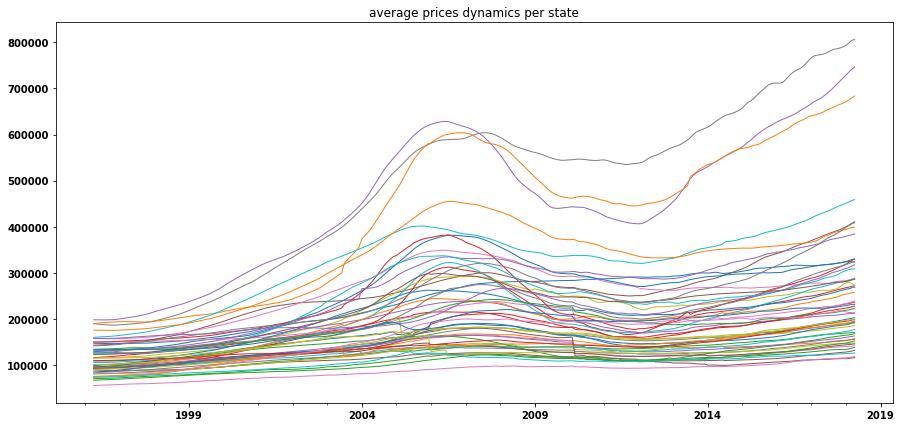

In [11]:
# 3.2.1. Price plot per state
df_state.plot(figsize=(15,7), legend=False, linewidth=1)
plt.title('average prices dynamics per state');

According to chart 3.2.1 - there are some similar trends and global seasonality (15+ year) with wide variance between states

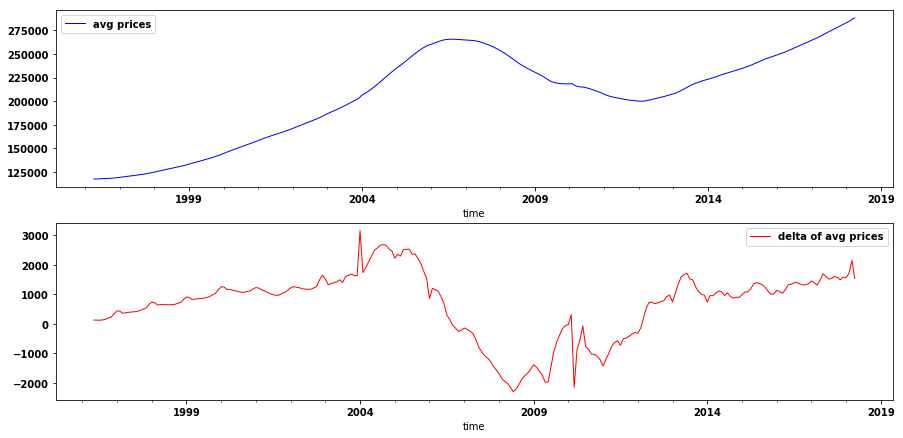

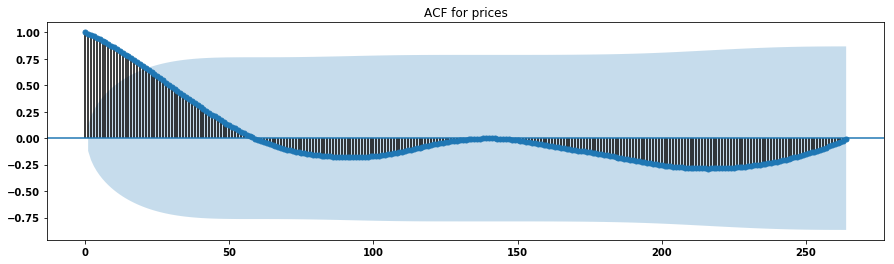

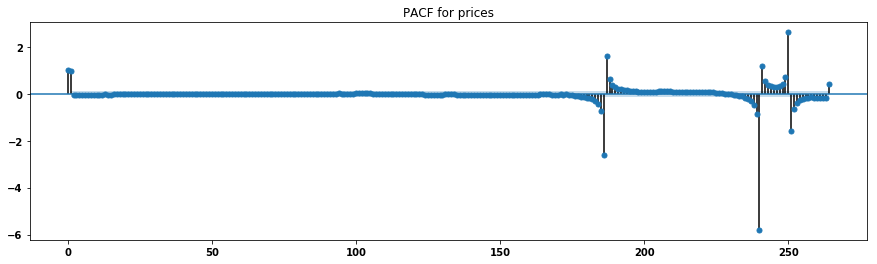

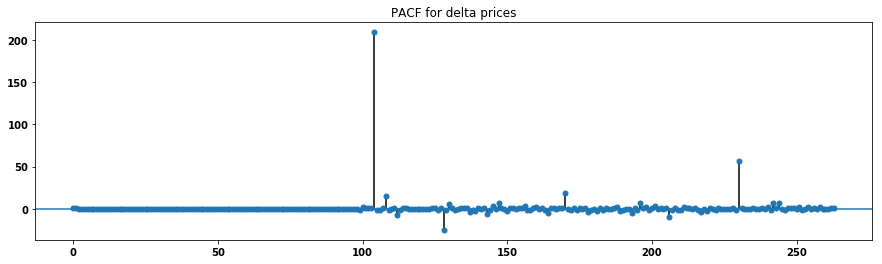

In [12]:
# 3.2.2. Plots on averaged prices
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,4

fig = plt.figure(figsize=(15,15))
plt.subplot(411)
ts_plot = ts_avg.plot(legend=True, label='avg prices',linewidth=1, c='b')
plt.legend(loc='best')
plt.subplot(412)
ts_delta_plot = ts_avg.diff(1).plot(legend=False, label='delta of avg prices',linewidth=1, c='r')
plt.legend(loc='best')
ts_acf_plot = plot_acf(ts_avg, title='ACF for prices')
ts_pacf_plot = plot_pacf(ts_avg, title='PACF for prices')
ts_pacf_plot = plot_pacf(ts_avg.diff(1).dropna(), title='PACF for delta prices');

Issues from 3.2.2:
  - all issues were based only *averaged* prices, so they could not reflect to some specific (outlier) regions
  - from the main chart positive trend (due to inflation, economic growth and/or rise of population) is noticed
  - we can see global (15+ years) seasonality (maybe due to economic cycles)
  - there is no clear correlation between prices for short-term periods (more than 1 month)
  - but we can see some correlation between prices for long-term periods (more than 100 month), which could be effect of global cycles
  - this time series will be used only for defining paramaters (p,q,d) for SARIMA models, which will be run separately on detailed time series

Now, let's run the same analysis for yearly-based time series

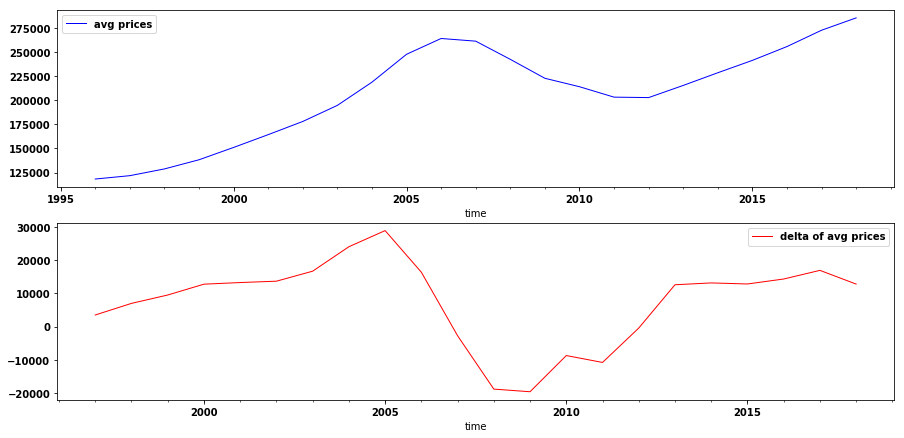

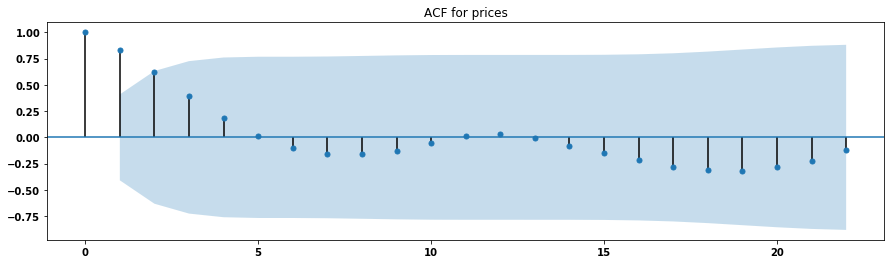

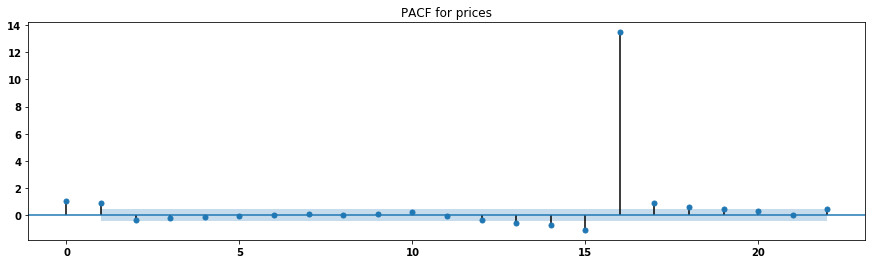

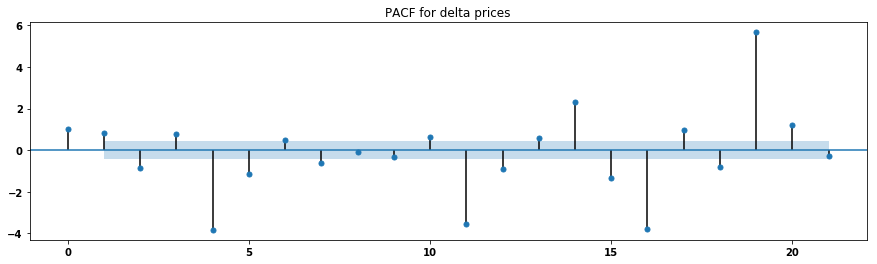

In [13]:
# 3.2.3. Plots on averaged prices per annum
fig = plt.figure(figsize=(15,15))
plt.subplot(411)
ts_plot = ts_avg_pa.plot(legend=True, label='avg prices',linewidth=1, c='b')
plt.legend(loc='best')
plt.subplot(412)
ts_delta_plot = ts_avg_pa.diff(1).plot(legend=False, label='delta of avg prices',linewidth=1, c='r')
plt.legend(loc='best')
ts_acf_plot = plot_acf(ts_avg_pa, title='ACF for prices')
ts_pacf_plot = plot_pacf(ts_avg_pa, title='PACF for prices')
ts_pacf_plot = plot_pacf(ts_avg_pa.diff(1).dropna(), title='PACF for delta prices');

Issues from 3.2.3:
  - shape of main chart is similar to the monthly based time series, so we can argue that intra-year fluctiation is not significant
  - from ACF and PACF we have 1-year autocorrelation factor

Now, let's compare 12-month rolling mean prices with monthly prices

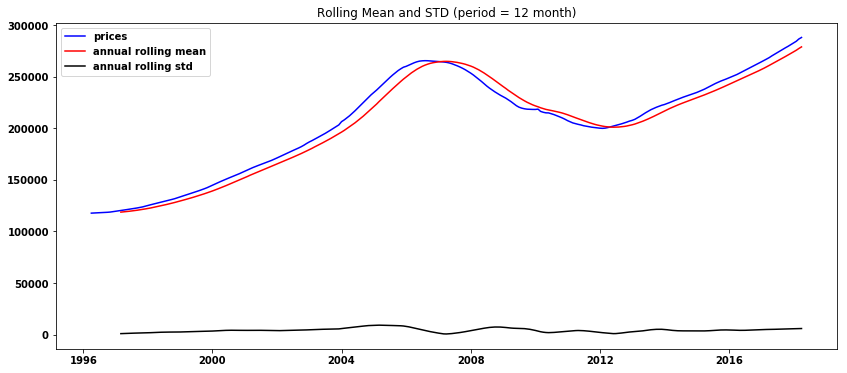

In [14]:
# 3.2.4. Rolling plot (per annum)
rollmean_yearly = ts_avg.rolling(window=12, center=False).mean()
rollstd_yearly = ts_avg.rolling(window=12, center=False).std()
fig = plt.figure(figsize=(14,6))
orig = plt.plot(ts_avg, c='b', label='prices')
mean = plt.plot(rollmean_yearly, c='r', label='annual rolling mean')
std = plt.plot(rollstd_yearly, c='black', label='annual rolling std')
plt.legend()
plt.title('Rolling Mean and STD (period = 12 month)');

Issues from 3.2.4:
  - shapes of charts above are similar to each other, variance quite stable
  - based on that and in order to reduce calculation complexity, let's do further modelling on annualy based datasets
  - but before that let's test averaged prices on stationarity

In [15]:
# 3.3.1 Stationarity test (DF-test) on monthly based prices
ts_test = adfuller(ts_avg)
test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print ('Results of Dickey-Fuller Test:')
print(60*'.')
print(test_output)

Results of Dickey-Fuller Test:
............................................................
Test Statistic                  -1.914667
p-value                          0.325193
#Lags Used                       2.000000
Number of Observations Used    262.000000
dtype: float64


As expected, prices time serie has no stationarity (p-value = 0.32 > 0.05)  
Now, let's run prices per annum

In [16]:
# 3.3.2 Stationarity test (DF-test) on yearly based prices
ts_test = adfuller(ts_avg_pa)
test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print ('Results of Dickey-Fuller Test:')
print(60*'.')
print(test_output)

Results of Dickey-Fuller Test:
............................................................
Test Statistic                 -2.266979
p-value                         0.182839
#Lags Used                      9.000000
Number of Observations Used    13.000000
dtype: float64


And the same conclusion for yearly based prices -  time serie has no stationarity (p-value = 0.18 > 0.05)  
Now let's run ADF-test on delta prices (1-period diff)

In [17]:
# 3.3.3 Stationarity tests on delta prices
ts_test = adfuller(ts_avg.diff(1).dropna())
test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print ('Results of Dickey-Fuller Test for monthly delta prices:')
print(60*'.')
print(test_output)
print(60*'_')
ts_test = adfuller(ts_avg_pa.diff(1).dropna())
test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print ('Results of Dickey-Fuller Test for annualy delta prices:')
print(60*'.')
print(test_output)

Results of Dickey-Fuller Test for monthly delta prices:
............................................................
Test Statistic                  -2.560185
p-value                          0.101509
#Lags Used                      13.000000
Number of Observations Used    250.000000
dtype: float64
____________________________________________________________
Results of Dickey-Fuller Test for annualy delta prices:
............................................................
Test Statistic                -1.073751e+01
p-value                        2.873735e-19
#Lags Used                     9.000000e+00
Number of Observations Used    1.200000e+01
dtype: float64


Time serie has stationarity only for annualy based diff.prices (p-value < 0.05)  

# Step 4: SARIMA modelling on averaged prices

The main goal of this step - is to define optimal parameters (pqd) for further modelling on annual prices

In [18]:
# 4.1. SARIMA model run on limited combinations (0 and 1) for pdq with s = 1
s = 1
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(ts_avg_pa, order=comb, seasonal_order=combs,
                                            enforce_stationarity=False, enforce_invertibility=False)

            output = model.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}{} : AIC Calculated ={}'.format(comb, combs, s, output.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq        (0, 1, 1)
pdqs    (0, 1, 1, 1)
aic          375.721
Name: 27, dtype: object

                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                   23
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 1)   Log Likelihood                -184.861
Date:                           Sun, 13 Oct 2019   AIC                            375.721
Time:                                   21:32:59   BIC                            378.392
Sample:                               01-01-1996   HQIC                           376.089
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3141      0.099      3.178      0.001       0.120       0.508
ma.S.L1        0.3141      0.099      3.178

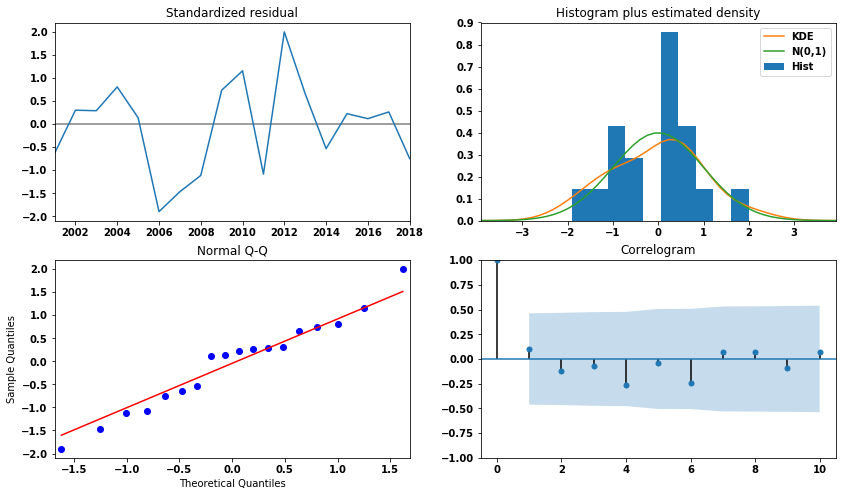

In [19]:
# 4.2 Now, let's check forecast quality on optimal parameters
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts_avg_pa, order=(0, 1, 1), seasonal_order=(0, 1, 1, 1), 
                                        enforce_stationarity=False, enforce_invertibility=False)
output = ARIMA_MODEL.fit()
print(output.summary())
output.plot_diagnostics(figsize=(14, 8));

Residuals are close to Gaussian white noise with moderate level

MSE for forecast: 2725127576.0438657


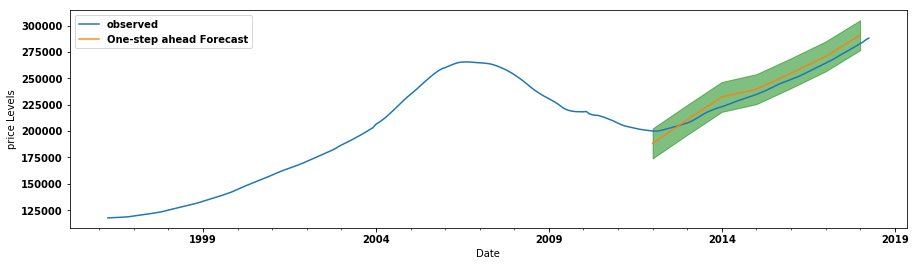

In [40]:
# 4.3 Now, let's look on forecast chart
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False) #prediction wrapper
pred_conf = pred.conf_int()
ax = ts_avg['1995':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='g', alpha=.5)
ax.set_xlabel('Date')
ax.set_ylabel('price Levels')
plt.legend();

prices_forecasted = pred.predicted_mean
prices_true = ts_avg['2012-01-01']
mse = ((prices_forecasted - prices_true) ** 2).mean()
print(f'MSE for forecast: {mse}')

for 2-years period MSE for forecast: 152134405.0
for 5-years period MSE for forecast: 791921341.0
for 7-years period MSE for forecast: 1491841214.0


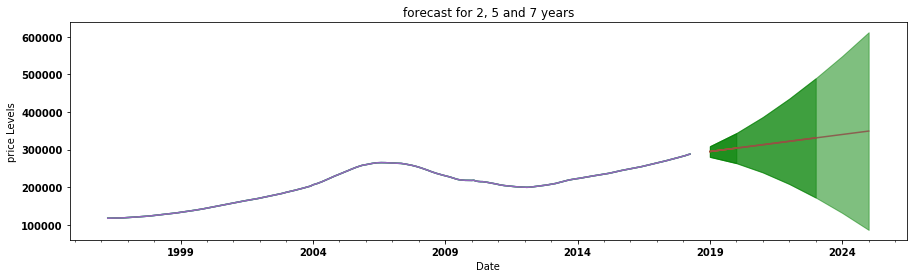

In [21]:
# 4.4 Now, let's look on forecast chart for the future periods
future_periods = [2, 5 ,7]
for period in future_periods:
    prediction = output.get_forecast(steps=period)
    pred_conf = prediction.conf_int()
    ax = ts_avg['1996-04-01':].plot(label='observed')
    prediction.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
    ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='g', alpha=.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('price Levels')
    prices_forecasted = prediction.predicted_mean
    prices_true = ts_avg['2018-04-01']
    mse = ((prices_forecasted - prices_true) ** 2).mean()
    print(f'for {period}-years period MSE for forecast: {round(mse,0)}')
#plt.legend(loc=2);
plt.title('forecast for 2, 5 and 7 years');

Issues:
  - we have obtained here ARIMA(0,1,1) model, but its' forecasting power is quite limited by period of forecast.
  - if we look to static forecasting results (chart in 4.3) - it seems quite good with low level of significance borders
  - but using the model for future forecasting with dynamics mechanism gives us significance increase in possible variance (and risk in terms of finance). 
  - so, I propose to limit forecasting period by 5 years for further works.

# Step 5: SARIMAX modelling on the Dataset

**General algorithm for ranking**
- key target of this section is to run SARIMAX-models on all considered time series
- to do that, I've prepared class (`Single_Model`) and function (`create_performance_df`) in 5.1

- `Single_Model` class create model instance for given single time serie (`ts`) and SARIMAX parameters (`order` and `seasonal_order`) and contains the following functions:
  - print model result table (`show_model_result()`)
  - plot set of diagnostics plots (`show_model_diagnostics_plots()`)
  - return aic-value (`model_aic()`)
  - create dataframe with forecast and significance levels bounds (`create_forecast(length)`)
    - the forecast is starts from 1-period after last date from original time serie
    - required parameter `length` - is define length of forecast
  - plot original time serie and forecasted (with bounds) `plot_forecast(length)`
    - this function works independently from `create_forecast` and requires the same parameter `length`
  - calculate 3 IRR (Internal Rate of Return) (`calculate_irr`) for low_bound, base forecast and high_bound on given forecast period, which is defined by given `length`
  - each IRR calculated based on simplified one-time bond repayment scheme cash flow with inverse of sign (price on last dataset period treated as investment, cash inflow is price_forecast on last forecast year)
  - this class used by `create_performance_df` function, but could be used mannualy for selected time series
  
- The function `create_performance_df` is generate df with investment KPI (profit and risk) and AIC for each row from given df
  - df - must have contains time-series in cols with datetime index (as in 3.1)
  - location_name - is string description for column_names
  - general parameters (p,q,d) are fixed as numbers (from Step4)
  - time series are compared with BENCHMARK_AIC (AIC from averaged prices) and those with better aic are collected to resulting dataframe as index (names of TS)
  - for each TS in the dataframe IRR as measure of profit and (IRRmax - IRRmin) as measure of risk calculated for 1, 3 and 5 years forecast and collected to the dataframe
  - based on data in the dataframe future ranking will be applied in STEP 6.
  - this function is uses Single_Model class in automatic way

- I have prepared 3 performance dataframes for future ranking:
  - `df_state_performance` - based on average annual prices per state
  - `df_county_performance` - based on average annual prices per county
  - `df_region_performance` - based on average annual prices per region (original df)

In [22]:
# 5.1. User's class and function
# 5.1.1 Class for forecast
class Single_Model:
    """This class created instance for SARIMA model with given time serie (ts) in long-format, order (p,d,q) and
seasonal_order (P,D,Q,s);
have internal functions:
- show_model_result() -> return sarimax.output summary;
- model_aic() -> return aic from model;
- show_model_diagnostics_plots() -> generate validation plots from sarimax function;
- create_forecast(length) -> create dataframe with forecasted values and conf_interval values on given length;
- plot_forecast(length) -> create dataframe as for create_forecast() and plot results in conf-ints
- calculate_irr(length) -> create list with IRRlow (lower conf_interval), IRR base and IRRhigh based on generated FCF on given forecast length
    """
    
    def __init__(self, ts, order, seasonal_order):
        self.ts = ts
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = sm.tsa.statespace.SARIMAX(self.ts, order = self.order, seasonal_order = self.seasonal_order, 
                                        enforce_stationarity=False, enforce_invertibility=False)
        self.output = self.model.fit()
        
    def show_model_results(self):
        print(self.output.summary())
        
    def model_aic(self):
        return self.output.aic
    
    def show_model_diagnostics_plots(self):
        self.output.plot_diagnostics(figsize=(14, 8));
        
    def create_forecast(self, length):
        _pred = self.output.get_forecast(steps=length)
        _bounds = _pred.conf_int()
        _pred = _pred.predicted_mean
        self.forecast = pd.concat([_pred, _bounds], axis=1)
        self.forecast = self.forecast.rename(columns={0:'mean_case'})       
        return self.forecast
    
    def plot_forecast(self, length):
        _first_date = self.ts.index[0]
        _forecast = self.create_forecast(length)
        _ax = self.ts[_first_date:].plot(label='observed')
        _forecast.iloc[:,0].plot(ax=_ax, label='One-step ahead Forecast', alpha=.9)
        _ax.fill_between(_forecast.index, _forecast.iloc[:, 1], _forecast.iloc[:, 2], color='g', alpha=.5)
        _ax.set_xlabel('Date')
        _ax.set_ylabel('price Levels')
        plt.legend(loc=2);
        plt.title(f'forecast for {length} periods')
        plt.show()
    
    def calculate_irr(self, length):
        _investment = self.ts[-1]
        _forecast = self.create_forecast(length)
        _low_fcf, _base_fcf, _high_fcf = np.zeros(length+1), np.zeros(length+1), np.zeros(length+1)
        _low_fcf[0], _base_fcf[0], _high_fcf[0] = -_investment,-_investment,-_investment
        _low_fcf[-1] = _forecast.iloc[-1,1]
        _base_fcf[-1] = _forecast.iloc[-1,0]
        _high_fcf[-1] = _forecast.iloc[-1,2]
        _irr = [round(np.irr(case),4) for case in [_low_fcf, _base_fcf, _high_fcf]]
        return _irr

# 5.1.2 General looping function
def create_performance_df(df, location_name):
    """the function generates dataframe with aic, profit and risk estimations for 1, 3 and 5 years based on given df in long format;
Location_name is a column-name in STR which corresponds to 1 of location type (Region, State, etc.) from original df;
df - in this function is a name of prepared df for modelling (in long-format);
The function calls instances from Single_Model class for each row in df, but with fixed SARIMA-params inside this function;
Before collecting results (AIC, IRRbase, IRRhigh - IRRlow), it filter it with Benchmark AIC (from calling Single_Model on averaged prices);
    """
    
    ORDER = (0, 1, 1)
    SEASONAL_ORDER = (0, 1, 1, 1)
    BENCHMARK_AIC = Single_Model(ts_avg_pa, ORDER, SEASONAL_ORDER).model_aic()
    results = pd.DataFrame([])
    index_list,aic_list,profit_1_list,risk_1_list = [], [], [] ,[]
    profit_3_list, risk_3_list, profit_5_list, risk_5_list= [], [], [], []
    for location in df:
        ts = df[location]
        model = Single_Model(ts, ORDER, SEASONAL_ORDER)
        aic = model.model_aic()
        if aic <= BENCHMARK_AIC:
            index_list.append(location)
            aic_list.append(aic)
            irr_1, irr_3, irr_5 = model.calculate_irr(1), model.calculate_irr(3), model.calculate_irr(5)
            profit_1, profit_3, profit_5 = irr_1[1], irr_3[1], irr_5[1]
            risk_1, risk_3, risk_5 = abs(irr_1[2]-irr_1[0]), abs(irr_3[2]-irr_3[0]), abs(irr_5[2]-irr_5[0])
            profit_1_list.append(profit_1)
            profit_3_list.append(profit_3)
            profit_5_list.append(profit_5)
            risk_1_list.append(risk_1)
            risk_3_list.append(risk_3)
            risk_5_list.append(risk_5)
    results[location_name] = index_list
    results['AIC'] = aic_list
    results['1-year IRR'] = profit_1_list
    results['1-year risk'] = risk_1_list
    results['3-years IRR'] = profit_3_list
    results['3-years risk'] = risk_3_list
    results['5-years IRR'] = profit_5_list
    results['5-years risk'] = risk_5_list
    results.set_index(location_name, drop=True, inplace=True)
    return results

In [23]:
# 5.2 Prepare performance df for state and county
df_state_performance = create_performance_df(df_state_pa,'State')
df_county_performance = create_performance_df(df_county_pa,'County')

print('performance matrix for state averaged price forecasts')
display(df_state_performance.head())
print('performance matrix for county averaged price forecasts')
display(df_county_performance.head())

performance matrix for state averaged price forecasts


,AIC,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
State,,,,,,,
AK,361.020459,0.0172,0.0562,0.0170,0.0665,0.0167,0.0766
AL,351.967922,0.0376,0.0921,0.0363,0.1175,0.0351,0.1368
AR,338.992038,0.0262,0.0729,0.0253,0.1011,0.0246,0.1215
GA,369.900384,0.0364,0.1189,0.0348,0.1664,0.0336,0.2036
IA,334.877298,0.0224,0.0533,0.0219,0.0632,0.0214,0.0723


performance matrix for county averaged price forecasts


,AIC,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
County,,,,,,,
Adams,363.624869,0.0430,0.0874,0.0412,0.1059,0.0397,0.1202
Aiken,364.097382,0.0373,0.1808,0.0358,0.2396,0.0346,0.3044
Alamance,340.252541,0.0423,0.0705,0.0406,0.0783,0.0391,0.0862
Alamosa,360.054793,0.0254,0.1172,0.0232,0.1096,0.0223,0.1181
Albany,356.366668,0.0661,0.0742,0.0632,0.1140,0.0598,0.1345


In [24]:
# 5.3. Prepare performance df for region
# WARNING: this cell will take 4-7 minutes
df_region_performance = create_performance_df(df_region_pa,'Region')

print('performance matrix for price forecasts per region')
display(df_region_performance.head())

performance matrix for price forecasts per region


,AIC,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
Region,,,,,,,
79936,371.240810,0.0181,0.2027,0.0177,0.2270,0.0174,0.2774
77084,354.398362,0.0268,0.0946,0.0261,0.1379,0.0255,0.1701
37013,355.071874,0.0700,0.0739,0.0651,0.1011,0.0614,0.1153
37211,375.417117,0.0610,0.1053,0.0574,0.1429,0.0545,0.1663
78660,365.199910,0.0416,0.0861,0.0397,0.0886,0.0382,0.0959


# Step 6: Ranking

General target in this Step - is to define top 5 best targets for each datasets (States, Counties, Regions):
  - 2 key metrics for investment performance: IRR and difference in IRRmax and IRRmin
  - Main algorythm for getting trade-off of these metrics is based on the following:
      - top_5 = {Sorted_best_profit} intersection {Sorted_lowest_risk} with len(top_5) = 5
      - this mechanism realised in function `get_ranked_results` in 6.1
  - It is important to say that rankings are made simultaneously for 1, 3 and 5-years forecast horizon, but results shouldn't be compared for different horizons  
  - `get_ranked_results(performance_df, top_number, profit_col, risk_col)` description
    - `performance_df` - is the resulting df from the function `create_performance_df`
    - `top_number` - is number for selecting TOP results
    - `profit_col` - is a string name for profit column from `performance_df`
    - `risk_col` - is a string name for profit column from `performance_df`

In [25]:
# 6.1. User's function
def get_ranked_results(performance_df, top_number, profit_col, risk_col):
    """
    this function makes ranking procedure on given performance_df and collect top_number of best rows from given df;
because performance_df has profit and risk columns for 1, 3 and 5 years, an user must specify names in str for 
profit_col and risk_col (e.g. '1-year IRR' and '1-year risk') as the cols in performance_df named
    """
    
    df = pd.DataFrame(performance_df, columns=[profit_col,risk_col])
    sorted_profit = df.sort_values(by = [profit_col], ascending = [False]).iloc[:,0].index
    sorted_risk = df.sort_values(by = [risk_col], ascending = [True]).iloc[:,1].index
    top_set = set()
    for i, j in zip(sorted_profit, sorted_risk):
        limit = len(top_set)
        if limit>=top_number:
            break
        top_set.add(i)
        top_set.add(j)
    top_set = list(top_set)
    filtered_df = df.loc[top_set]
    if len(filtered_df)>top_number:
        x = len(filtered_df) - top_number
        filtered_df = filtered_df.iloc[:-x]
    return filtered_df

In [26]:
# 6.2 Generating ranked tables for States, Counties and Regions
# 6.2.1. States
df_state_ranked_1_year = get_ranked_results(df_state_performance, 5, '1-year IRR', '1-year risk')
df_state_ranked_3_year = get_ranked_results(df_state_performance, 5, '3-years IRR', '3-years risk')
df_state_ranked_5_year = get_ranked_results(df_state_performance, 5, '5-years IRR', '5-years risk')
df_state_ranked = pd.concat([df_state_ranked_1_year, df_state_ranked_3_year, df_state_ranked_5_year], axis=1)

# 6.2.2. Counties
df_county_ranked_1_year = get_ranked_results(df_county_performance, 5, '1-year IRR', '1-year risk')
df_county_ranked_3_year = get_ranked_results(df_county_performance, 5, '3-years IRR', '3-years risk')
df_county_ranked_5_year = get_ranked_results(df_county_performance, 5, '5-years IRR', '5-years risk')
df_county_ranked = pd.concat([df_county_ranked_1_year, df_county_ranked_3_year, df_county_ranked_5_year], axis=1)

# 6.2.3. Regions
df_region_ranked_1_year = get_ranked_results(df_region_performance, 5, '1-year IRR', '1-year risk')
df_region_ranked_3_year = get_ranked_results(df_region_performance, 5, '3-years IRR', '3-years risk')
df_region_ranked_5_year = get_ranked_results(df_region_performance, 5, '5-years IRR', '5-years risk')
df_region_ranked = pd.concat([df_region_ranked_1_year, df_region_ranked_3_year, df_region_ranked_5_year], axis=1)

In [27]:
# 6.3 Let's look on the results
print('TOP 5 STATES')
display(df_state_ranked)
print(80*'-')

print('TOP 5 COUNTIES')
display(df_county_ranked)
print(80*'-')

print('TOP 5 REGIONS')
display(df_region_ranked)
print(80*'-')

TOP 5 STATES


,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
AK,NaN,NaN,0.0170,0.0665,0.0167,0.0766
IA,0.0224,0.0533,0.0219,0.0632,0.0214,0.0723
NE,0.0490,0.0777,0.0466,0.0750,0.0447,0.0788
OH,0.0395,0.0861,0.0380,0.0959,0.0367,0.1065
OK,0.0199,0.0551,NaN,NaN,NaN,NaN
SD,0.0407,0.0560,0.0391,0.0637,0.0377,0.0705


--------------------------------------------------------------------------------
TOP 5 COUNTIES


,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
Allegheny,0.0444,0.0548,NaN,NaN,NaN,NaN
Chemung,NaN,NaN,0.0198,0.0470,NaN,NaN
Coshocton,NaN,NaN,NaN,NaN,0.0101,0.0373
Dubuque,NaN,NaN,0.0249,0.0459,0.0233,0.0421
Erie,0.0423,0.0425,0.0406,0.0447,NaN,NaN
Keweenaw,NaN,NaN,NaN,NaN,0.1284,0.2739
Maury,0.0955,0.1204,0.0876,0.1207,0.0812,0.1241
Pontotoc,0.0920,0.1228,0.0849,0.1104,0.0789,0.1099
West Baton Rouge,0.0208,0.0540,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
TOP 5 REGIONS


,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
Region,,,,,,
14414,0.0530,0.0409,NaN,NaN,NaN,NaN
14423,0.0391,0.0371,NaN,NaN,NaN,NaN
14485,0.0438,0.0408,NaN,NaN,NaN,NaN
17701,NaN,NaN,0.0225,0.0212,0.0215,0.0129
17702,NaN,NaN,0.0175,0.0206,0.0187,0.0122
19023,0.2644,0.2512,0.2186,0.2787,0.1869,0.2817
44102,0.1894,0.5449,0.1618,0.5611,0.1426,NaN
65255,NaN,NaN,0.0184,0.0146,0.0169,0.0087


--------------------------------------------------------------------------------


- Tables above do not provide absolutely best "champions", because trade-off between profit and risk couldn't be solved easily
- also, it could be noticed, that IRR amplitude (risk) is risen by increasing forecast horizon, so it is due to model forecasting power
- let's choose 9 examples from each tables with "balanced" KPI:
- for the States:
  - best State for short-term (1-year) investments: SD (4.1% +/- 2.8%)
  - best State for mid-term (3-year) investments: NE (4.7% +/- 3.7%)
  - best State for long-term investments (5-year): NE (4.5% +/- 3.8%)
- for the Counties:
  - best County for short-term investments: Erie (4.2% +/- 2.0%)
  - best County for mid-term investments: Erie (4.1% +/- 2.2%)
  - best County for long-term investments: Pontotoc (4.5% +/- 3.8%)
- for the Regions:
  - best Region for short-term investments: 14414 (5.3% +/- 2.1%)
  - best Region for mid-term investments: 17701 (2.2% +/- 1%)
  - best Region for long-term investments : 17701 (2.1% +/- 0.6%)

aic  for averaged prices is 375.7
3-years forecast for benchmark model


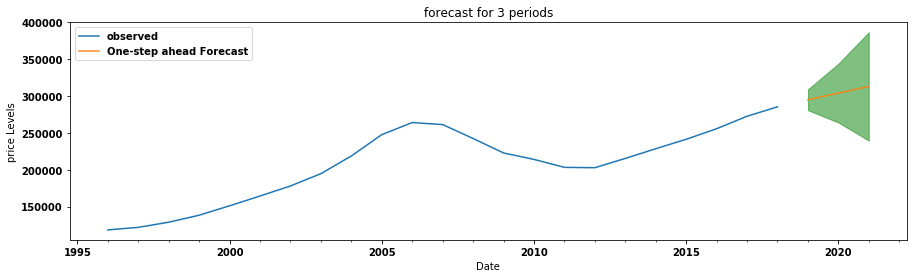

for SD aic is 342.3
3-years forecast for SD


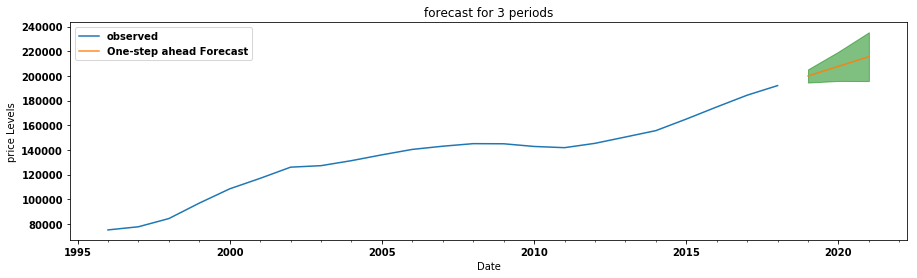

for NE aic is 349.5
3-years forecast for NE


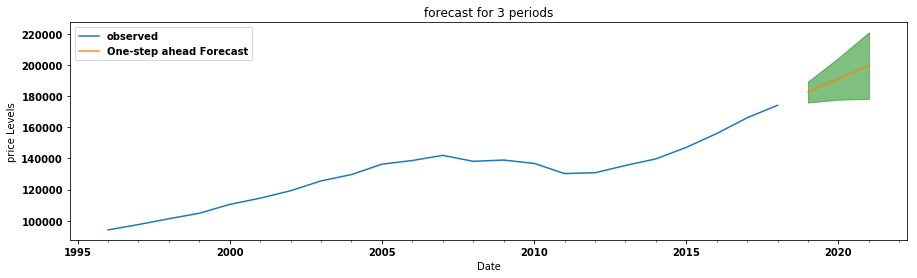

In [28]:
# 6.4. Forecast visualizing
best_states = ['SD','NE']
best_counties = ['Erie','Pontotoc']
best_regions = [14414, 17701]

ORDER = (0, 1, 1)
SEASONAL_ORDER = (0, 1, 1, 1)

benchmark_model = Single_Model(ts_avg_pa, ORDER, SEASONAL_ORDER)
print(f'aic  for averaged prices is {round(benchmark_model.model_aic(),1)}')
print(f'3-years forecast for benchmark model')
benchmark_model.plot_forecast(3)

for state in best_states:
    model = Single_Model(df_state_pa[state], ORDER, SEASONAL_ORDER)
    print(f'for {state} aic is {round(model.model_aic(),1)}')
    print(f'3-years forecast for {state}')
    model.plot_forecast(3)

for Erie aic is 326.8
3-years forecast for Erie


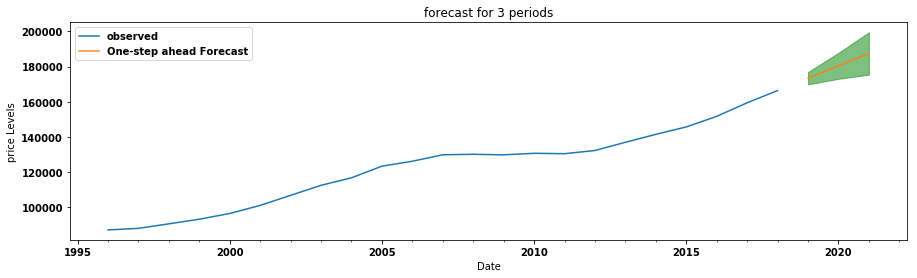

for Pontotoc aic is 339.6
3-years forecast for Pontotoc


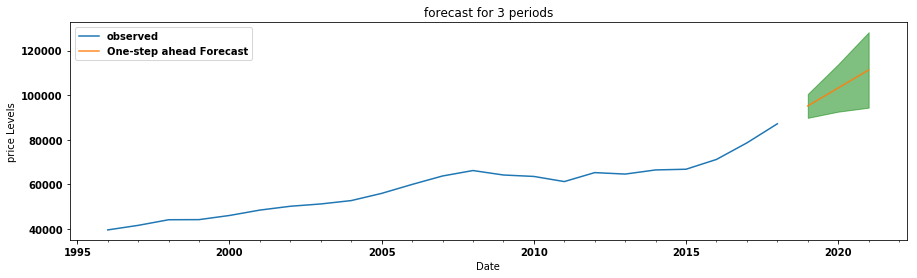

In [29]:
for county in best_counties:
    model = Single_Model(df_county_pa[county], ORDER, SEASONAL_ORDER)
    print(f'for {county} aic is {round(model.model_aic(),1)}')
    print(f'3-years forecast for {county}')
    model.plot_forecast(3)  

for 14414 aic is 321.0
3-years forecast for 14414


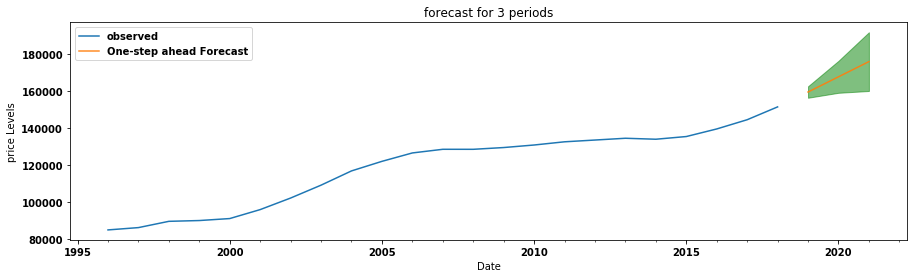

for 17701 aic is 346.2
3-years forecast for 17701


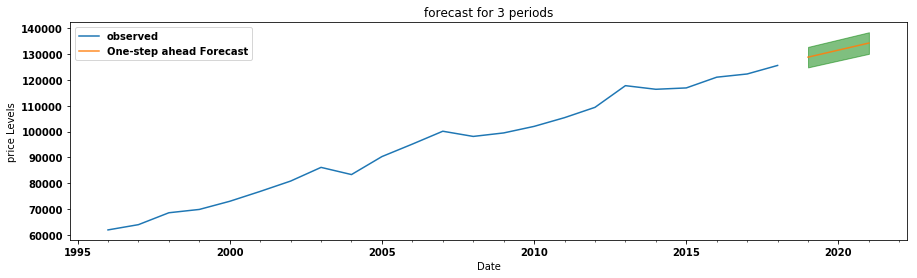

In [30]:
for region in best_regions:
    model = Single_Model(df_region_pa[region], ORDER, SEASONAL_ORDER)
    print(f'for {region} aic is {round(model.model_aic(),1)}')
    print(f'3-years forecast for {region}')
    model.plot_forecast(3)

In general, forecast quality for specific locations are better than for averaged prices, as it shown above

# Step 7: Detailed approach

In previous steps I've tried to optimize calculation time by 2 important assumptions:
  - I have used unified SARIMA-parameters to all models (obtained from averaged prices time serie)
  - I resized datasets from Monthly based index to Annual based index  

Now, let's discover, how forecast will be changed by changing these assumptions.  

For the first assumption I've made some modifications to `Single_Model` class and `create_performance_df` function, which calculate to each TS a separate optimal parameters (not unified). In order to make calculations faster, let's compare results on annualy based prices per State

In [31]:
# 7.1. Updated class and function
class Single_Model1:
    """this class create an instance as Single_Model class, but with the following differences:
- it takes as inputs pqd range in iterative array (pqd_range) and s;
- for each of row in given ts in calculate a set of models (from param range) and fix unique optimal SARIMA params;
- output and derivate function are based on the optimal params"""
    
    def __init__(self, ts, pqd_range, s):
        self.ts = ts
        self.pqd_range = pqd_range
        self.s = s
        self.best_params = self._define_optimal_params()
        self.order = self.best_params[0]
        self.seasonal_order = self.best_params[1]
        #self.order = (0,1,1)
        #self.seasonal_order = (0,1,1,1)
        self.model = sm.tsa.statespace.SARIMAX(self.ts, order = self.order, seasonal_order = self.seasonal_order, 
                                        enforce_stationarity=False, enforce_invertibility=False)
        self.output = self.model.fit()
    
    def _define_optimal_params(self):
        p = d = q = self.pqd_range
        pdq = list(itertools.product(p, d, q))
        pdqs = [(x[0], x[1], x[2], self.s) for x in list(itertools.product(p, d, q))]
        _ans = []
        for comb in pdq:
            for combs in pdqs:
                try:
                    _model = sm.tsa.statespace.SARIMAX(self.ts, order=comb, seasonal_order=combs,
                                                enforce_stationarity=False, enforce_invertibility=False)
                    _output = _model.fit()
                    _ans.append([comb, combs, _output.aic])
                except:
                    continue
        ans_df = pd.DataFrame(_ans, columns=['pdq', 'pdqs', 'aic'])
        #display(ans_df)
        best_params = ans_df.loc[ans_df['aic'].idxmin()]
        return best_params
    
    def show_model_results(self):
        print(self.output.summary())
        
    def model_aic(self):
        return self.output.aic
    
    def show_model_diagnostics_plots(self):
        self.output.plot_diagnostics(figsize=(14, 8));
        
    def create_forecast(self, length):
        _pred = self.output.get_forecast(steps=length)
        _bounds = _pred.conf_int()
        _pred = _pred.predicted_mean
        self.forecast = pd.concat([_pred, _bounds], axis=1)
        self.forecast = self.forecast.rename(columns={0:'mean_case'})       
        return self.forecast
    
    def plot_forecast(self, length):
        _first_date = self.ts.index[0]
        _forecast = self.create_forecast(length)
        _ax = self.ts[_first_date:].plot(label='observed')
        _forecast.iloc[:,0].plot(ax=_ax, label='One-step ahead Forecast', alpha=.9)
        _ax.fill_between(_forecast.index, _forecast.iloc[:, 1], _forecast.iloc[:, 2], color='g', alpha=.5)
        _ax.set_xlabel('Date')
        _ax.set_ylabel('price Levels')
        plt.legend(loc=2);
        plt.title(f'forecast for {length} periods')
        plt.show()
    
    def calculate_irr(self, length):
        _investment = self.ts[-1]
        _forecast = self.create_forecast(length)
        _low_fcf, _base_fcf, _high_fcf = np.zeros(length+1), np.zeros(length+1), np.zeros(length+1)
        _low_fcf[0], _base_fcf[0], _high_fcf[0] = -_investment,-_investment,-_investment
        _low_fcf[-1] = _forecast.iloc[-1,1]
        _base_fcf[-1] = _forecast.iloc[-1,0]
        _high_fcf[-1] = _forecast.iloc[-1,2]
        _irr = [round(np.irr(case),4) for case in [_low_fcf, _base_fcf, _high_fcf]]
        return _irr

def create_performance_df1(df, location_name):
    """this function create a df as create_performance_df(), but with the following differences:
- it contains s=1 and pqd_range = range(0,2);
- it calls Single_Model1 class for generating model instances;
- it adds a column with Optimal SARIMA params for each row in resulting df
"""
    s = 1
    pqd_range = range(0,2)
    BENCHMARK_AIC = Single_Model1(ts_avg_pa, pqd_range, s).model_aic()
    results = pd.DataFrame([])
    index_list,aic_list, params_list, profit_1_list,risk_1_list = [], [], [] ,[], []
    profit_3_list, risk_3_list, profit_5_list, risk_5_list= [], [], [], []
    for location in df:
        ts = df[location]
        model = Single_Model1(ts, pqd_range, s)
        params = (model.order, model.seasonal_order)
        aic = model.model_aic()
        if aic <= BENCHMARK_AIC:
            index_list.append(location)
            aic_list.append(aic)
            params_list.append(params)
            irr_1, irr_3, irr_5 = model.calculate_irr(1), model.calculate_irr(3), model.calculate_irr(5)
            profit_1, profit_3, profit_5 = irr_1[1], irr_3[1], irr_5[1]
            risk_1, risk_3, risk_5 = abs(irr_1[2]-irr_1[0]), abs(irr_3[2]-irr_3[0]), abs(irr_5[2]-irr_5[0])
            profit_1_list.append(profit_1)
            profit_3_list.append(profit_3)
            profit_5_list.append(profit_5)
            risk_1_list.append(risk_1)
            risk_3_list.append(risk_3)
            risk_5_list.append(risk_5)
    results[location_name] = index_list
    results['AIC'] = aic_list
    results['PARAMS'] = params_list
    results['1-year IRR'] = profit_1_list
    results['1-year risk'] = risk_1_list
    results['3-years IRR'] = profit_3_list
    results['3-years risk'] = risk_3_list
    results['5-years IRR'] = profit_5_list
    results['5-years risk'] = risk_5_list
    results.set_index(location_name, drop=True, inplace=True)
    return results

In [32]:
# 7.2. Generating ranking table
# warning: this cell execution takes 3-5 min
df_state_performance1 = create_performance_df1(df_state_pa,'State')
df_state_ranked_1_year1 = get_ranked_results(df_state_performance1, 5, '1-year IRR', '1-year risk')
df_state_ranked_3_year1 = get_ranked_results(df_state_performance1, 5, '3-years IRR', '3-years risk')
df_state_ranked_5_year1 = get_ranked_results(df_state_performance1, 5, '5-years IRR', '5-years risk')
df_state_ranked1 = pd.concat([df_state_ranked_1_year1, df_state_ranked_3_year1, df_state_ranked_5_year1], axis=1)

print('Part of performance table')
display(df_state_performance1.head(10))
print(80*'_')
print('TOP 5 STATES - detailed approach')
display(df_state_ranked1)
print(80*'-')

Part of performance table


,AIC,PARAMS,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
State,,,,,,,,
AK,357.742189,"((0, 1, 1), (1, 1, 1, 1))",0.0192,0.0511,0.0178,0.0609,0.0173,0.0650
AL,351.967922,"((0, 1, 1), (0, 1, 1, 1))",0.0376,0.0921,0.0363,0.1175,0.0351,0.1368
AR,338.992038,"((0, 1, 1), (0, 1, 1, 1))",0.0262,0.0729,0.0253,0.1011,0.0246,0.1215
GA,369.900384,"((0, 1, 1), (0, 1, 1, 1))",0.0364,0.1189,0.0348,0.1664,0.0336,0.2036
IA,334.228033,"((1, 1, 1), (0, 1, 1, 1))",0.0113,0.0478,0.0173,0.0641,0.0179,0.0724
IL,369.843498,"((0, 1, 1), (0, 1, 1, 1))",0.0151,0.1133,0.0144,0.1819,0.0141,0.2420
IN,329.298447,"((0, 1, 1), (0, 1, 1, 1))",0.0335,0.0599,0.0317,0.0928,0.0306,0.1136
KY,336.908000,"((0, 1, 1), (0, 1, 1, 1))",0.0276,0.0621,0.0266,0.0839,0.0259,0.0993
LA,343.183994,"((0, 1, 1), (0, 1, 1, 1))",0.0008,0.0777,-0.0006,0.1285,-0.0009,0.1705


________________________________________________________________________________
TOP 5 STATES - detailed approach


,1-year IRR,1-year risk,3-years IRR,3-years risk,5-years IRR,5-years risk
AK,0.0192,0.0511,0.0178,0.0609,0.0173,0.0650
IA,0.0113,0.0478,0.0173,0.0641,0.0179,0.0724
NE,0.0490,0.0777,0.0466,0.0750,0.0447,0.0788
OH,0.0395,0.0861,0.0380,0.0959,0.0367,0.1065
SD,0.0407,0.0560,0.0391,0.0637,0.0377,0.0705


--------------------------------------------------------------------------------


In [33]:
print(Single_Model1.__doc__)

this class create an instance as Single_Model class, but with the following differences:
- it takes as inputs pqd range in iterative array (pqd_range) and s;
- for each of row in given ts in calculate a set of models (from param range) and fix unique optimal SARIMA params;
- output and derivate function are based on the optimal params


In [34]:
# 7.3. Comparison
filtered_states = set(df_state_performance.index)
filtered_states1 = set(df_state_performance1.index)
print(f'overall states from main approach is {len(filtered_states)}, from alternative detailed approach is {len(filtered_states1)}')
print(f'number of matching states is {len(filtered_states.intersection(filtered_states1))}')

top5_states = set(df_state_ranked.index)
top5_states1 = set(df_state_ranked1.index)
print(f'top5 states from main approach is {len(top5_states)}, from alternative detailed approach is {len(top5_states1)}')
print(f'number of matching states in top5 is {len(top5_states.intersection(top5_states1))}')

overall states from main approach is 25, from alternative detailed approach is 25
number of matching states is 25
top5 states from main approach is 6, from alternative detailed approach is 5
number of matching states in top5 is 5


As we can see from 7.3, despite of the fact, that in detailed approach we used separate parameters which lead to some changes in forecasts, all states are the same in terms of ranking. 
In the top5 set we obtained 6 states because it is outer join for 1, 3, and 5-years subsets

Now, let's look on second assumption

Before run code below, there are some important points:
- I didn't put here all loops for defining "BEST" SARIMA parameter, since such code take a lot of time for execution (several hours)
- I realized, that increasing s-param will reduce aic, so I fixed it as 12 month
- I limited p,q and d values by range from 0 to 2. Increasing this param to bigger values significantly increase calculation time
- So relatively optimal params chosen for comparison are the following:
  - (p,d,q) = (1,2,2)
  - (P,D,Q,S) = (2,2,2,12)
  - obtained AIC = 3084
- for comparison purposes I've run averaged price time series

In [35]:
# 7.4. Initialising model instances
ORDER_pa = (0, 1, 1)
SEASONAL_ORDER_pa = (0, 1, 1, 1)
ORDER_pm = (1, 2, 2)
SEASONAL_ORDER_pm = (2, 2, 2, 12)

base_model = Single_Model(ts_avg_pa, ORDER_pa, SEASONAL_ORDER_pa)
monthly_model = Single_Model(ts_avg, ORDER_pm, SEASONAL_ORDER_pm)

annual model aic: 376.0, monthly model aic: 3084.0
ANNUAL MODEL residuals analysis


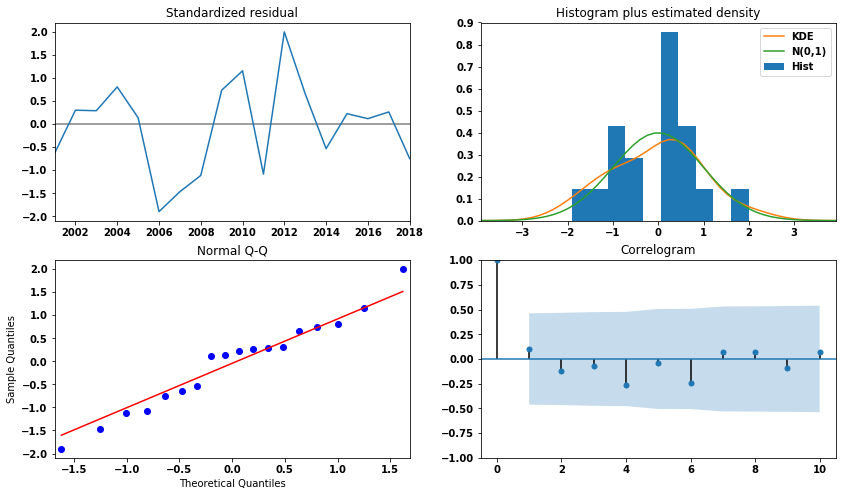

In [36]:
# 7.5. Models validation results
# 7.5.1. Annual model
aic_pa = base_model.model_aic()
aic_pm = monthly_model.model_aic()
print(f'annual model aic: {round(aic_pa,0)}, monthly model aic: {round(aic_pm,0)}')
print('ANNUAL MODEL residuals analysis')
base_model.show_model_diagnostics_plots()

MONTHLY MODEL residuals analysis


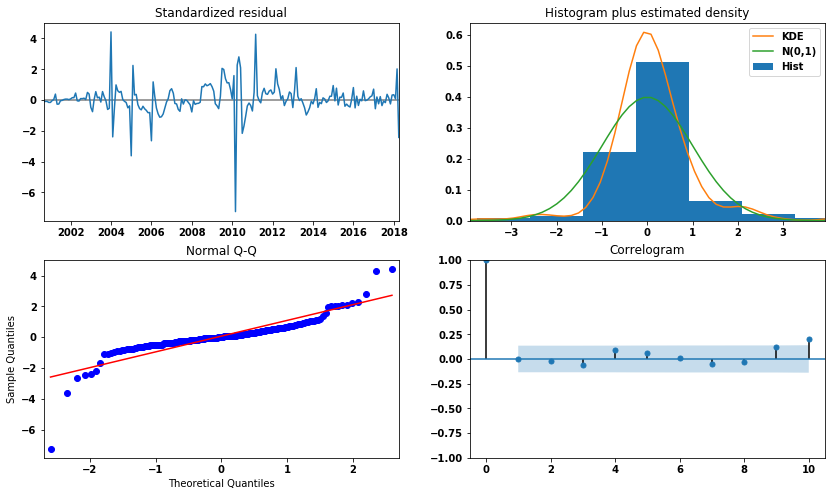

In [37]:
# 7.5.2. Monthly model
print('MONTHLY MODEL residuals analysis')
monthly_model.show_model_diagnostics_plots()

We can observe, that quality of monthly model is much lower, tham of annual model (AIC is higher, residuals less close to Normal Distribution)  
Now, let's compare forecast charts (to 3 years)

Annual forecast


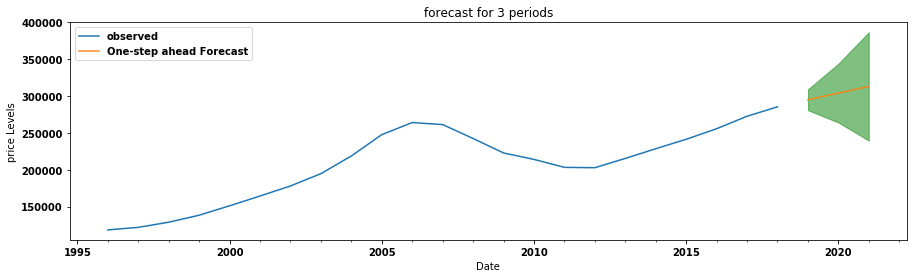

Monthly forecast


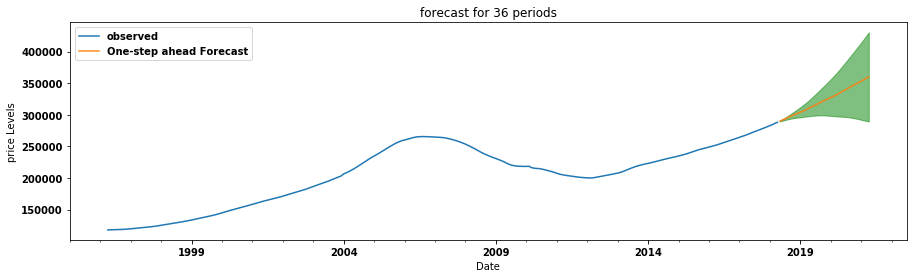

In [38]:
for model, horizon, descr in zip((base_model, monthly_model), (3,36), ('Annual forecast', 'Monthly forecast')):
    print(descr)
    model.plot_forecast(horizon)

Surprisingly, but monthly model forecast has better quality of forecasting, mainly due to smaller period size. This fact tells us, that in general smaller scale of period has potential of obtaining better forecasting models, so the only problem here is to optimize calculation time.  
Finding optimal "trade-off" between detalization level and complexity is one the main goal here.

# Step 8: Technical Conclusions 

- **The dataset has very detalised price indicators for real estate in USA and contains time series for ~ 15000 regions**


- **According to visual analysis, more or less all time series have some similar dynamics, especially by global trends**


- **Based on the fact above and for EDA purposes and some other code simplifications, 1 special time serie from averaged prices was created**


- **This ts showed unstationarity (ADF-tests) and the way to get stationarity for it contains rescaling it to annual base with 1 period difference**


- **The averaged price ts was used to obtain optimal parameters for SARIMA model (0,1,1)(0,1,1,1), which used for detailed models**


- **Fitting detailed models (per State, per County and per Region) showed moderate level of forecast quality and here 3-5 years of forecast horizon could recommended as upper limit**


- **As additional task, I've calculated set of models with different SARIMA parameters (instead of using the one from average price TS), which significantly increases calculation complexity, but not influenced on ranking conclusions. So, here, we can state that using "average" SARIMA parameters is a reasonable decision**


- **Also, models were fitted on original monthly based index: this significantly increased calculation time, but it will make forecast a little better and smoother**

# Step 9: Business Findings

- **The given dataset provides to create and fit forecasting models on real estate prices**


- **As measure for investment KPI 2 parameters were chosen:**
  - ***IRR as a profit measure***
  - ***spread of IRR (IRRmax - IRRmin) as a risk measure***


- **Because of forecasting power limits, 3 horizons were chosen for KPI evaluation: 1, 3 and 5 year**


- **Ranking mechanism was based of the trade-off between both KPI**


- **Ranking results for initial Question: TOP5 regions for investments:**
  - ***for 1-year INVESTMENTS: 14414, 14423, 14485, 19023, 44102***
  - ***for 3-year and 5-year INVESTMENTS: 17701, 17702, 19023, 44102, 65255***
  
- **3-years top5 best region are shown in map bellow**


- **Additionally, top5 States and top5 Counties were defined (based on aggregated prices):**
  - ***top5 best States:***
    - ***for 1-year payback investments: IA, NE, OH, OK, SD***
    - ***for 3-5-year paybackinvestments: AK, IA, NE, OH, SD***
  - ***top5 best Counties:***
    - ***for 1-year payback investments: Erie, Keweenaw, Maury, Pontonoc, West Baton Rouge***
    - ***for 3-year payback investments: Erie, Keweenaw, Maury, Pontonoc, Dubuque***
    - ***for 5-year payback investments: Keweenaw, Maury, Pontonoc, Dubuque, Pittsylvania***
  

In [39]:
region_dict = dict()
region_dict[44102] = (41.473, -81.736)
region_dict[17701] = (41.257, -77.011)
region_dict[19023] = (39.916, -75.265)
region_dict[17702] = (41.222, -77.023)
region_dict[65255] = (39.105, -92.235)
region_dict[14414] = (42.899, -77.734)
region_dict[14423] = (42.938, -77.835)
region_dict[14485] = (42.879, -77.602)

# source of lat and long: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/

top5_region_map = folium.Map(location=region_dict[44102],min_zoom=4, max_zoom=5)
for key, value in region_dict.items():
    marker = folium.Marker(location=[value[0], value[1]], popup=key, tooltip=key)
    marker.add_to(top5_region_map)

display(top5_region_map)
top5_region_map.save("map.html")

# Step 10: Future Work

- **Continue to discover ways for optimizing calculation complexity for monthly based index in order to increase forecast power**


- **Expand possible investments KPI for measuring finance indicators for ranking purposes**


- **Adding some macroeconomic data to original dataset for understanding global and local (per State) predictors on prices (e.g. GDP growth rate, migration flows)**